# Modèle Baseline: Régression logistique

In [1]:
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Maths modules
from scipy.stats import f_oneway
import pandas as pd

from sklearn.linear_model import LogisticRegression
# precision, recall, f1-score,
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizers, Stemmers and Lemmatizers
import nltk
from nltk.corpus import stopwords
import spacy
# Download resources
nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doly9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
all_data = pd.read_csv('D:/openclassroom/projet7/input/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1', names=["target", "id", "date", "flag", "user", "text"])

In [4]:
all_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
all_data.shape

(1600000, 6)

In [6]:
labels = all_data['target'].unique()
print(labels)

[0 4]


In [7]:
# Drop useless columns
all_data.drop(columns=["id", "date", "flag", "user"], inplace=True)

# Replace target values with labels
all_data.target = all_data.target.map(
    {
        0: "NEGATIVE",
        4: "POSITIVE",
    }
)

In [101]:
sample_size = 20000
df = all_data.sample(sample_size, random_state=42)

In [8]:
df = all_data

['NEGATIVE' 'POSITIVE']


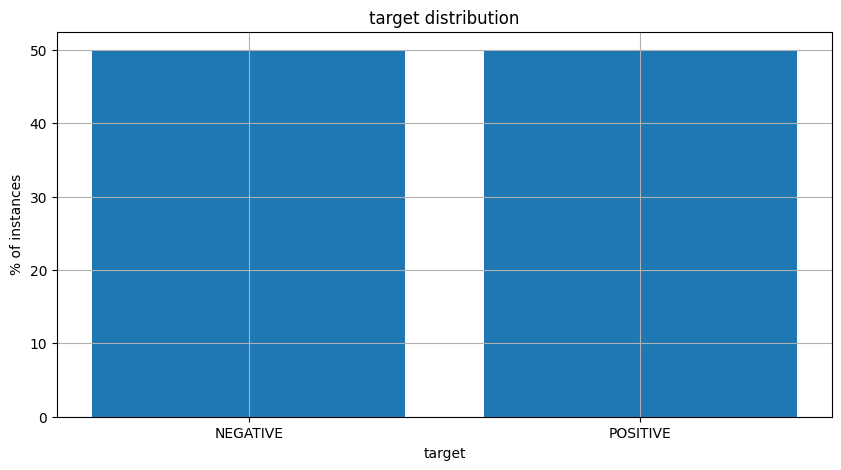

In [9]:
# the histogram of the data
labels = all_data['target'].unique()
print(labels)
post_total = len(all_data)
df1 = all_data.groupby(['target']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('target')
plt.title('target distribution')
plt.grid(True)
plt.show()

## Prétraitement de texte

In [10]:

# remove special characters
def remove_special_characters(texts):
    #Removing numerical values, Removing Digits and words containing digits
    l_texts= texts.apply(lambda x: re.sub('\w*\d\w*','', x))
    #Removing punctations
    l_texts= l_texts.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    #Removing Extra Spaces
    l_texts = l_texts.apply(lambda x: re.sub(' +', ' ',x))
    # remove stock market tickers like $GE
    l_texts = l_texts.apply(lambda x: re.sub(r'\$\w*', '',x))
    # remove old style retweet text "RT"
    l_texts = l_texts.apply(lambda x: re.sub(r'^RT[\s]+', '',x))
    # remove hyperlinks
    l_texts = l_texts.apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '',x))
    # remove hashtags
    # only removing the hash # sign from the word
    l_texts = l_texts.apply(lambda x: re.sub(r'#', '',x))

    return l_texts

def tokenize_stopwords_lemmatize(texts, allowed_postags=['NOUN','ADJ','ADV']):
    tokenized_docs = texts.apply(lambda x: ' '.join([token.lemma_.lower() for token in list(nlp(x)) if token.is_alpha and not token.is_stop]))
    return tokenized_docs

In [11]:
texts = remove_special_characters(df.text)
tokenized_docs = tokenize_stopwords_lemmatize(texts)
print(tokenized_docs)

0          switchfoot httptwitpiccom awww s bummer should...
1          upset not update facebook texte cry result sch...
2             kenichan dive time ball manage save rest bound
3                                  body feel itchy like fire
4                           nationwideclass behave m mad not
                                 ...                        
1599995                        wake have school good feeling
1599996    thewdbcom cool hear old walt interview httpblipfm
1599997                       ready mojo makeover ask detail
1599998      happy birthday boo alll time tupac amaru shakur
1599999          happy charitytuesday thenspcc sparkscharity
Name: text, Length: 1600000, dtype: object


In [12]:
df.shape

(1600000, 2)

In [14]:
df_tokenized_docs = df.copy()
df_tokenized_docs['text_tokenized'] = tokenized_docs
df_tokenized_docs.head()

,target,text,text_tokenized
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not


In [16]:
df_tokenized_docs.to_csv('D:/openclassroom/projet7/input/df_tokenized_docs.csv',index=False)

## Feature Extraction

In [103]:
#vectorizer = CountVectorizer()     
vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(tokenized_docs)
df_doc_vec = pd.DataFrame(doc_vec.toarray(),columns=vectorizer.get_feature_names_out())
df_doc_vec.head()

,aa,aaaaaaaaaaaw,aaaaaaaaah,aaaaaargh,aaaaah,aaaaahhhhhh,aaaaargh,aaaah,aaaamazing,aaaamerah,...,zzzzzzzzz,zzzzzzzzzz,zzzzzzzzzzzzzzzz,µè,àª,âµ,èªª,ðº,ðºð,ññðºð
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train and test the model

In [104]:
X = df_doc_vec

In [105]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    df.target,
    test_size=0.2,
    stratify=df.target,
    random_state=42,
)

## Logistic Regression

In [107]:

# build Logistic Regression
LR_model = LogisticRegression(solver='liblinear', C=10, n_jobs=-1, max_iter=500, tol=0.0001, verbose=2)

# training!
LR_model.fit(X_train,y_train)

# predict!
y_train_pred = LR_model.predict(X_train)
y_test_pred = LR_model.predict(X_test)

C:\Users\doly9\Anaconda3\envs\projet7env\Lib\site-packages\sklearn\linear_model\_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


[LibLinear]

In [108]:
# accuracy

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.96
testing accuracy: 0.74


In [109]:

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.71      0.73      1988
    POSITIVE       0.73      0.76      0.75      2012

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



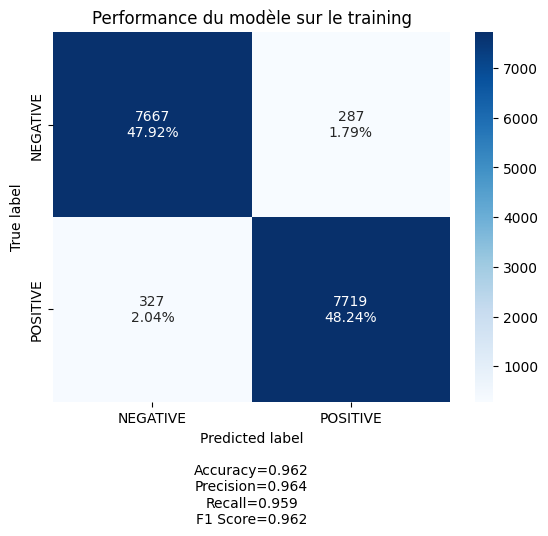

In [116]:
cf = confusion_matrix(y_train, y_train_pred)
make_confusion_matrix(cf, categories=['NEGATIVE', 'POSITIVE'], title = "Performance du modèle sur le training")

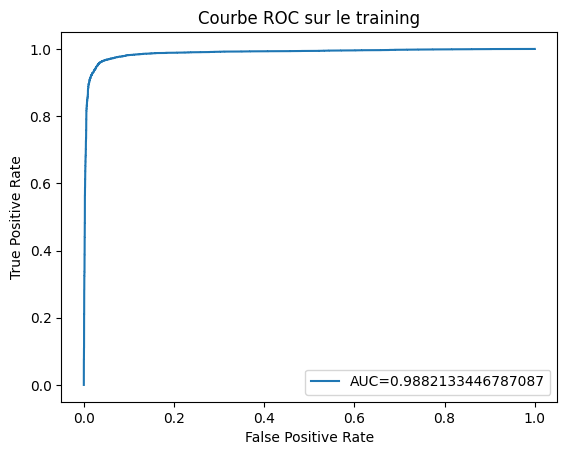

In [131]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
l_y_train = labelencoder.fit_transform(y_train)
#define metrics
y_pred_proba = LR_model.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(l_y_train,  y_pred_proba)
auc = metrics.roc_auc_score(l_y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Courbe ROC sur le training")
plt.show()

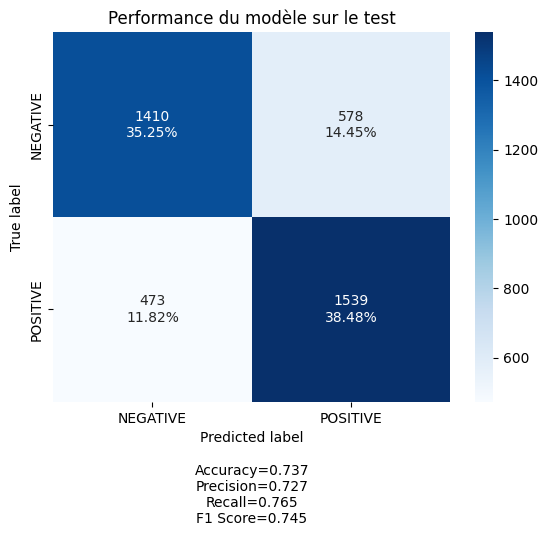

In [117]:
cf = confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(cf, categories=['NEGATIVE', 'POSITIVE'], title = "Performance du modèle sur le test")

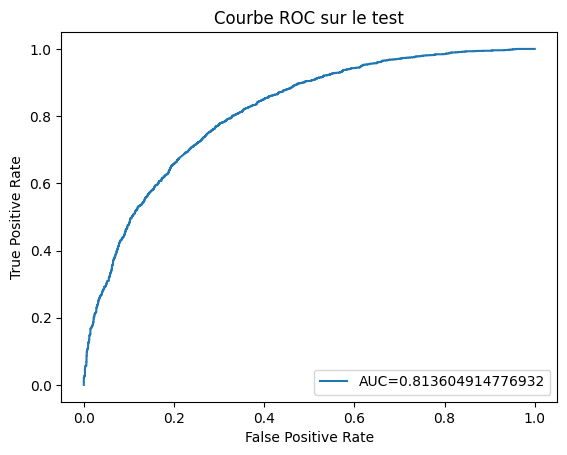

In [130]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
l_y_test = labelencoder.fit_transform(y_test)
#define metrics
y_pred_proba = LR_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(l_y_test,  y_pred_proba)
auc = metrics.roc_auc_score(l_y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Courbe ROC sur le test")
plt.show()